## **Appendix B - Reliable Shortest Path using Mixed-Integer Programming**

**Course:** AER1516 - Motion Planning for Robotics

**Due:** 22 April 2022

**Team:** Vishal Kanna Annand, Andrew Constantinescu, Sugumar Prabhakaran

### **Introduction**

This code here is to implent a mixed integer program (MIP) or a mixed integer linear program (MILP) to solve the spatially dependent reliable shortest path problem.  Please see Section 4 of our paper for details on the implementation.

In [1]:
# import necessary modules
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import norm
from math import sqrt

# install gurobi industrial MIP solver
!pip install gurobipy
import gurobipy as gp

In [2]:
# ****INPUT YOUR OWN ACADEMIC LICENSE grbgetkey****

# Create environment with WLS license
e = gp.Env(empty=True)
# e.setParam('WLSACCESSID', 'XXXXXXXX-XXXX-XXXX-XXXX-XXXXXXXXXXXXX')
# e.setParam('WLSSECRET', 'XXXXXXXX-XXXX-XXXX-XXXX-XXXXXXXXXXXXX')
# e.setParam('LICENSEID', XXXXXX)

e.start()

# Create the model within the Gurobi environment
model = gp.Model(env=e)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID
Academic license - for non-commercial use only - registered to s.prabhakaran@mail.utoronto.ca


### **Mathematical Formulation**

**User Defined Parameters**
* $N$: set of nodes, with $N = \{1, 2, ..., n\}$
* $A$: set of arcs, with $A = \{a_{ij},...\}$, where $a_{ij}$: link from node $i$ to node $j$
* $T_{ij} = (t_{ij}, \sigma_{ij})$:  the normal distribution (mean, std deviation) of travel time for link $a_{ij}$
* $r, s$: start and end nodes respectively 
* $\alpha$: User defined confidence level ($\alpha> 0.5$: risk-averse, $\alpha=0.5$: risk-neutral, $\alpha < 0.5$: risk-seeking)

**Decision Variables**
* $x_{ij} \in \{0,1\}$: binary decision variable signifying link-path incidence - i.e. if link is on path = 1
* $y_{ab}$: binary decision variable that means link $a \in A$ connects to link $b \in A$

**Objective Function**
* $\Phi^{-1}(\alpha) = \sum_{a_{ij} \in A}t_{ij}\cdot x_{ij} + z_{\alpha}\cdot \sqrt \{\sum_{a_{ij} \in A}(\sigma_a)^2 \cdot x_{ij} + 2\cdot \sum_{a_{ij} \in A}\sum_{b_{ij} \in A}(\sigma_{ab}\cdot y_{ab})\}$, where:
* $\Phi^{-1}(\alpha)$: is the inverse cumulative density function (cdf) of the overall path travel time that we want to minimize as a function of $\alpha$
* $z_{\alpha}$: Is the inverse cdf of a standard normal distribution at a $\alpha$ confidence level
* $(\sigma_a)^2$: variance of link $a_{ij}$
* $\sigma_{ab} = $: covariance between link $a_{ij}$ and link $b_{ij}$


In [13]:
# USER DEFINED PARAMETERS
scenario = 2

if scenario == 1:
    n = 5               # number of nodes
    r = 1               # start node
    s = 5               # finish node
    alpha = 0.1         # user defined risk tolerance threshold

    N = [i for i in range(1, n+1)]                      # Set of nodes
    A = [(1,2), (1,3), (1,4), (2,3), (3,5), (4,5)]      # Set of arcs
    A_w = [(1,2, 2), (1,3, 3), (1,4, 4), (2,3, 2), (3,5, 4), (4,5, 4)] # incl wts
    t_ij = {(i,j):k for (i,j,k) in A_w}                 # dict of mean time for arc
    idx = {(j,k):i for i, (j,k) in enumerate(A)}    # index needed for dict later

    cov_matrix = np.array([[ 2.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [-1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                        [-1.0,-0.5, 1.0, 0.0, 0.0, 0.0],
                        [ 2.0,-1.0,-0.3, 2.0, 0.0, 0.0],
                        [ 0.3, 1.5,-0.4, 2.0, 6.0, 0.0],
                        [-0.2,-0.6, 0.5,-0.4,-1.5, 1.0]])
    
    positions = {1:[1,3], 2:[3,4], 3:[3,3], 4:[3,2], 5:[5,3]} #for visualization
                   
elif scenario == 2:
    n = 14              # number of nodes
    r = 1               # start node
    s = 14              # finish node
    alpha = 0.374       # user defined risk tolerance threshold
    z = norm.ppf(alpha) # calculate inv. cdf of std normal distr at alpha confidence

    N = [i for i in range(1, n+1)]                              # Set of nodes
    A = [(1, 2), (1, 3), (1, 4), (2, 5), (2, 6), (3, 5), (3, 6),# Set of arcs
         (3, 7), (4, 6), (4, 7), (5, 8), (6, 9), (7, 9), (8, 10), 
         (9, 11), (11, 10), (10, 12), (10, 13), (11, 13), (12, 14), (13, 14)]   
    A_w = [(1, 2, 3), (1, 3, 1), (1, 4, 1), (2, 5, 2), (2, 6, 3), # incl wts
           (3, 5, 2),(3, 6, 7), (3, 7, 1), (4, 6, 7), (4, 7, 3), (5, 8, 5), 
           (6, 9, 1), (7, 9, 6), (8, 10, 4), (9, 11, 2), (11, 10, 2),
           (10, 12, 1), (10, 13, 2), (11, 13, 1),(12, 14, 1), (13, 14, 4)] 
    t_ij = {(i,j):k for (i,j,k) in A_w}                 # dict of mean time for arc
    idx = {(j,k):i for i, (j,k) in enumerate(A)}    # index needed for dict later

    cov_matrix = np.array([[  2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  1, 0.1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  1,   2,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0, 0.5,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0, 0.2,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0, 0.1,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  2,   2,   2,   2,   2,   2,   2,   2,   9,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   2,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  0.7,   0,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   1,   0,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   2,   0,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   1,   0,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   1,   0,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0, 0.5,   0,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0, 0.2,   0,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   1,   0],
                           [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0, 0.1]])

    positions = {1:[1,3], 2:[3,4], 3:[3,3], 4:[3,2],    # for visualization
                 5:[5,4], 6:[5,3], 7:[5,2], 8:[7,3.5], 9:[7,2.5], 
                 10:[10, 3.5], 11:[8.5,2.5], 12:[12, 3.5], 13:[12,2.5],
                 14:[14, 3]}   

z = norm.ppf(alpha) # calculate inv. cdf of std normal distr at alpha confidence


{(1, 2): 3, (1, 3): 1, (1, 4): 1, (2, 5): 2, (2, 6): 3, (3, 5): 2, (3, 6): 7, (3, 7): 1, (4, 6): 7, (4, 7): 3, (5, 8): 5, (6, 9): 1, (7, 9): 6, (8, 10): 4, (9, 11): 2, (11, 10): 2, (10, 12): 1, (10, 13): 2, (11, 13): 1, (12, 14): 1, (13, 14): 4}


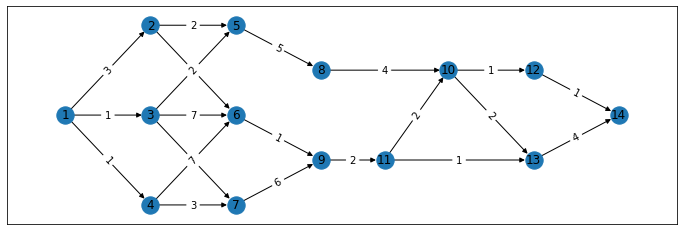

In [14]:
# VISUALIZE DIRECTED GRAPH

# create graph object and add nodes and edges with weights
plt.figure(figsize=(12,4))
G = nx.DiGraph()                
G.add_nodes_from(N)
G.add_weighted_edges_from(A_w)

# draw network
nx.draw_networkx(G, positions, with_labels=True)
nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=t_ij)
plt.show()

In [15]:
# INITIALIZE GUROBI MIP MODEL
model = gp.Model("reliable_shortest_path")
model.setParam('TimeLimit', 60) # seconds

Set parameter TimeLimit to value 60


In [16]:
# DECISION VARIABLES

x = model.addVars(A, vtype=gp.GRB.BINARY)   # link-path incidence
y = {}          # variable to store if link a connects to link b

# find all pair-combinations of links in set A and store index in dict
covar_arcs = [(a,b) for a in A for b in A if a != b]
covar_arcs_dict = {(a,b):i for i, (a,b) in enumerate(covar_arcs)}

# create a variable y[i] for each link-pair to store if they connect
for i in range(len(covar_arcs_dict)):
        y[i] = model.addVar(vtype=gp.GRB.BINARY)

# additional variables to linearize objective function
var = model.addVar(name='var')
covar = model.addVar(name='covar')
path_var = model.addVar(name='path_var')
path_std = model.addVar(name='path_std')

In [17]:
# CONSTRAINTS

# constraint (7) - ensures reliable shortest path is feasible
model.addConstrs(gp.quicksum(x[i,j] for j in G.successors(i))-
                 gp.quicksum(x[k,i] for k in G.predecessors(i)) == 1 
                 for i in N if i == r)
model.addConstrs(gp.quicksum(x[i,j] for j in G.successors(i))-
                 gp.quicksum(x[k,i] for k in G.predecessors(i)) == 0 
                 for i in N if (i != r and i != s))
model.addConstrs(gp.quicksum(x[i,j] for j in G.successors(i))-
                 gp.quicksum(x[k,i] for k in G.predecessors(i)) == -1 
                 for i in N if i == s)

# constraint to calculate y[i] based on if there is a path from a to b
for a in A:
    for b in A:
        if a!=b:
            model.addConstr(y[covar_arcs_dict[(a,b)]]==x[a]*x[b])

In [18]:
# OBJECTIVE FUNCTION

# objective function:  path mean + z*sqrt(var + covar)
path_mean = gp.quicksum(t_ij[a]*x[a] for a in A)
var = gp.quicksum(cov_matrix[idx[a],idx[a]]*x[a] for a in A)
covar = gp.quicksum(cov_matrix[idx[a], idx[b]]*y[covar_arcs_dict[(a,b)]] 
                                                  for a in A for b in A if a !=b)

#linearize sqrt in objective function
model.addConstr(path_var == var + 2*covar)
model.addGenConstrPow(path_var, path_std, 0.5)

model.modelSense = gp.GRB.MINIMIZE          # minimization
model.setObjective(path_mean+z*path_std)    # objective function
model.optimize()                            # execute

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to s.prabhakaran@mail.utoronto.ca
Optimize a model with 15 rows, 445 columns and 85 nonzeros
Model fingerprint: 0x0114f9d4
Model has 420 quadratic constraints
Model has 1 general constraint
Variable types: 4 continuous, 441 integer (441 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+01]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [3e-01, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve added 44 rows and 844 columns
Presolve time: 0.04s
Presolved: 671 rows, 1442 columns, 4862 nonzeros
Presolved model has 1 SOS constraint(s)
Variable types: 1102 continuous, 340 integer (339 binary)

Root relaxation: objective 1.132930e+01, 153 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |  

In [19]:
# OUTPUT RESULTS

print("Most Reliable Path at alpha=:", alpha)

for a in A:
    if x[a].x != 0:
        print(a)
print("Objective Function Value:", model.getObjective().getValue())

Most Reliable Path at alpha=: 0.374
(1, 2)
(2, 6)
(6, 9)
(9, 11)
(11, 10)
(10, 12)
(12, 14)
Objective Function Value: 11.887066836618601
